<a href="https://colab.research.google.com/github/jainsarthak2000/ML-Project-on-Hate-Speech-Detection-in-Hindi-English-Facebook-Posts/blob/main/ML%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emoji
!pip install emojis
!pip install -U nltk
!pip install emosent-py
!pip install profanity-check
!pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install inltk
!pip install indic-nlp-library

     |████████████████████████████████| 133kB 5.2MB/s 
     |████████████████████████████████| 1.5MB 5.8MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
  Created wheel for emosent-py: filename=emosent_py-0.1.6-cp37-none-any.whl size=28503 sha256=8b9cf2e173f1ed3da197668fc9d0d38af7c207a64430e1c210a9941c604ce5e3
  Stored in directory: /root/.cache/pip/wheels/46/32/3c/2e21c3622b77cdc89a38a711240588ac3cf9b8e805eed0f6e1
Successfully built emosent-py
     |████████████████████████████████| 2.4MB 5.6MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 111.8MB 52kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.3.1+cpu which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.3.1+cpu which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import re
from emoji import UNICODE_EMOJI
import emojis
from emosent import get_emoji_sentiment_rank
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline
from profanity_check import predict, predict_prob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from inltk import inltk
from inltk.inltk import setup
from inltk.inltk import tokenize
from nltk.util import ngrams
from sklearn.metrics import confusion_matrix

import sys
from indicnlp import common

from indicnlp import loader
from indicnlp.transliterate.unicode_transliterate import ItransTransliterator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git
!git clone https://github.com/TrigonaMinima/HinglishNLP.git

fatal: destination path 'indic_nlp_resources' already exists and is not an empty directory.
fatal: destination path 'indic_nlp_library' already exists and is not an empty directory.
fatal: destination path 'HinglishNLP' already exists and is not an empty directory.


In [ ]:
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"indic_nlp_resources"

# Add library to Python path
sys.path.append(r'{}\src'.format(INDIC_NLP_LIB_HOME))

# Set environment variable for resources folder
common.set_resources_path(INDIC_NLP_RESOURCES)

In [ ]:
#Import all the csv files

hindi_train_df = pd.read_csv("agr_hi_train.csv", header= None) # 12000 rows × 3 columns
hindi_test_df = pd.read_csv("agr_hi_fb_test.csv", header = None) #970 rows × 2 columns
hindi_validation_df = pd.read_csv("agr_hi_dev.csv", header = None) #3001 rows × 3 columns
hindi_surprise_df = pd.read_csv("agr_hi_sm_test.csv", header = None) #1194 rows × 2 columns

english_train_df = pd.read_csv("agr_en_train.csv", header = None) #11999 rows × 3 columns
english_test_df = pd.read_csv("agr_en_fb_test.csv", header = None) #916 rows × 2 columns
english_validation_df = pd.read_csv("agr_en_dev.csv", header = None) #3001 rows × 3 columns
english_surprise_df = pd.read_csv("agr_en_sm_test.csv", header = None) #1257 rows × 2 columns

#what is the _fb_gold, and tw_gold data sets?
english_fb_gold = pd.read_csv("agr_en_fb_gold.csv", header = None) #916 rows × 3 columns
english_tw_gold = pd.read_csv("agr_en_tw_gold.csv", header = None) #1257 rows × 3 columns
hindi_fb_gold =  pd.read_csv("agr_hi_fb_gold.csv", header = None) #970 rows × 3 columns
hindi_tw_gold = pd.read_csv("agr_hi_tw_gold.csv", header = None) #1194 rows × 3 columns

In [ ]:
#Combine train, validation and fb_gold sets into one for hindi and english separately
hindi_total = pd.concat([hindi_train_df, hindi_validation_df, hindi_fb_gold])
english_total = pd.concat([english_train_df, english_validation_df, english_fb_gold])

In [ ]:
#Cleaning the texts
def cleaner(df, set_language):
  df = df.rename(columns={1: "text", 2: "agression"})
  if set_language == "Hindi":
    loader.load()
    df["text"] = df["text"].apply(lambda x: ItransTransliterator.to_itrans(str(x), 'hi'))

  #remove html tags
  df["text"] = df["text"].apply(lambda x: re.sub("\n"," ", x))
  #remove urls
  df["text"] = df["text"].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

  if set_language == "English":
    df['tokenized'] = df["text"].apply(lambda x: nltk.WordPunctTokenizer().tokenize(x))
  if set_language == "Hindi":
    df['tokenized'] = df["text"].apply(lambda x: nltk.WordPunctTokenizer().tokenize(str(x)))
  return df

In [ ]:
sia = SentimentIntensityAnalyzer()

#returns numerical features related to emojis including emoji_sentiment, number 
#of emojis, probability of profanity, negativity score, neutraility score,
#positivity score, compound score as well as returns an array of 5grams
def average_emoji_sentiment(text):
  sentiment = 0
  emojis_in_list = emojis.get(text)
  number_of_emojis = len(emojis_in_list)
  for i in emojis_in_list:
    try:
      sentiment += get_emoji_sentiment_rank(i)["sentiment_score"]
    except KeyError:
      #cases where the emosentpy package is a little old for some emojis - 
      #only 4 in the whole dataset
      pass
  if number_of_emojis == 0:
    emoji_sentiment = 0.5
  else:
    emoji_sentiment = sentiment / number_of_emojis
  #using the profanity_check pacakage - https://pypi.org/project/profanity-check/
  profanity_prob = predict_prob([text])
  pols = sia.polarity_scores(text)
  neg_score = pols.get('neg')
  neutral_score = pols.get('neu')
  pos_score = pols.get('pos')
  compound_score = pols.get('compound')
  #creating 5-grams
  x = text.lower()
  x = re.sub(r'[^a-zA-Z0-9\s]', ' ', x)
  tokens = [char for char in x]
  ngram = list(ngrams(tokens, 5))
  ngram = [''.join(i) for i in ngram]
  return emoji_sentiment, number_of_emojis, profanity_prob[0], neg_score, neutral_score, pos_score, compound_score, ngram

#returns numerical features for each post such as number of punctuation per word,
# number of exclaimatory punctuations, number of hashtags, number of numbers and 
# number of capital words
def features(tokens):
  total_words = len(tokens)
  punctuations = 0
  exclaim = 0
  num_numbers = 0
  hashtags = 0
  capital_words = 0
  #string.punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
  exclamatory_puncs = ['!','?']
  for i in tokens:
    if i in string.punctuation:
      punctuations = punctuations + 1
    if i in exclamatory_puncs:
      exclaim += 1
    if "#" in i:
      hashtags += 1
    if i.isupper():
      capital_words += 1
    num_numbers += sum(c.isdigit() for c in i)
  if total_words == 0:
    return 0, 0, 0, 0, 0
  punc_per_word = punctuations/total_words
  exclaim_per_word = exclaim/total_words
  return punc_per_word, exclaim_per_word, hashtags, num_numbers, capital_words

In [ ]:
#Feature Extraction
def feature_extractor (df, lang):
  #extract emoji features from average_emoji_sentiment and make columns for each
  df['tempcol'] = df['text'].apply(lambda x: average_emoji_sentiment(x))
  new_col_list = ['emoji_sentiment', 'number_of_emojis', 'profanity_prob', 'neg_score', 'neutral_score', 'pos_score', 'compound_score', 'ngram_5']
  for n,col in enumerate(new_col_list):
    df[col] = df['tempcol'].apply(lambda tempcol: tempcol[n])
  df = df.drop('tempcol',axis=1)

  #extract other features and make columns for each feature
  df['temp_column'] = df['tokenized'].apply(lambda x: features(x))
  new_col_list = ['punc_per_word','exclamation_punc_per_word','hashtags','num_numbers', 'num_capital_words']
  for n,col in enumerate(new_col_list):
    df[col] = df['temp_column'].apply(lambda temp_column: temp_column[n])
  df = df.drop('temp_column',axis=1)

  df['num_words_in_post'] = df['tokenized'].apply(lambda x: len(x))
  return df

In [ ]:
def filter_stopwords (df, lang):
  if lang == "English":
    stop_words = set(stopwords.words('english'))
  if lang == "Hindi":
    filter_stop_words = []
    myfile = open("/content/HinglishNLP/data/assets/stop_hinglish", "r")
    myline = myfile.readline()
    while myline:
      l = str(myline).split('\n')[0]
      filter_stop_words.append(l)
      myline = myfile.readline()
    myfile.close()  
    stop_words = set(filter_stop_words)
  def filter_punc_stopwords_numbers(tokens):
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if w.isalpha()]
    return tokens
  df['filtered_tokenized'] = df['tokenized'].apply(lambda x: filter_punc_stopwords_numbers(x))
  return df

In [ ]:
#Clean the text
english_total = cleaner(english_total, "English")
hindi_total = cleaner(hindi_total, "Hindi")

#Extract features
english_total = feature_extractor(english_total, "English")
hindi_total = feature_extractor(hindi_total, "Hindi")

#Filter Stop Words
english_total = filter_stopwords(english_total, "English")
hindi_total = filter_stopwords(hindi_total, "Hindi")

KeyboardInterrupt: ignored

In [ ]:
hindi_total.describe()

,emoji_sentiment,number_of_emojis,profanity_prob,neg_score,neutral_score,pos_score,compound_score,punc_per_word,exclamation_punc_per_word,hashtags,num_numbers,num_capital_words,num_words_in_post
count,15971.000000,15971.000000,1.597100e+04,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000,15971.000000
mean,0.483984,0.104251,2.410853e-01,0.014603,0.964874,0.020209,0.011839,0.056592,0.003733,0.052282,1.320205,0.502786,33.859182
std,0.087363,0.539569,2.070749e-01,0.054237,0.091231,0.070924,0.234215,0.077568,0.020992,0.460958,7.806996,3.148174,59.838222
min,-1.000000,0.000000,1.478170e-10,0.000000,0.000000,0.000000,-0.980500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,1.129089e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,0.500000,0.000000,1.599436e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
75%,0.500000,0.000000,2.974237e-01,0.000000,1.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,34.000000
max,1.000000,18.000000,1.000000e+00,0.787000,1.000000,1.000000,0.997200,0.600000,0.500000,22.000000,351.000000,107.000000,1119.000000


In [ ]:
english_total.describe()

,emoji_sentiment,number_of_emojis,profanity_prob,neg_score,neutral_score,pos_score,compound_score,punc_per_word,exclamation_punc_per_word,hashtags,num_numbers,num_capital_words,num_words_in_post
count,15916.000000,15916.000000,1.591600e+04,15916.000000,15916.000000,15916.000000,15916.000000,15916.000000,15916.000000,15916.000000,15916.000000,15916.000000,15916.000000
mean,0.487240,0.098643,1.396394e-01,0.099736,0.772495,0.125060,0.039535,0.078978,0.010130,0.032609,1.099648,1.151294,28.335134
std,0.078305,0.658215,1.448667e-01,0.144912,0.194910,0.160439,0.491968,0.074963,0.034051,0.274600,6.833489,9.065668,44.060324
min,-0.400000,0.000000,6.806942e-13,0.000000,0.000000,0.000000,-0.999900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,6.245075e-02,0.000000,0.668000,0.000000,-0.318200,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,0.500000,0.000000,1.000732e-01,0.000000,0.789000,0.081000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,18.000000
75%,0.500000,0.000000,1.529708e-01,0.166000,0.925000,0.196000,0.440400,0.125000,0.000000,0.000000,0.000000,1.000000,31.000000
max,1.000000,16.000000,9.986500e-01,1.000000,1.000000,1.000000,1.000000,0.666667,0.500000,10.000000,551.000000,748.000000,1476.000000


In [ ]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokens):
  return [wn.lemmatize(w) for w in tokens]

english_total['lemmatized_tokens'] = english_total['filtered_tokenized'].apply(lambda x: lemmatizing(x))
hindi_total['lemmatized_tokens'] = hindi_total['filtered_tokenized'].apply(lambda x: lemmatizing(x))
#making text lowercase for use in the vectorizer
english_total['lower_case_text'] = english_total['text'].apply(lambda x: x.lower())
hindi_total['lower_case_text'] = hindi_total['text'].apply(lambda x: x.lower())
#making lemmatized tokens into string for tfidf vectorizer
english_total['lemmatized_text']=english_total['lemmatized_tokens'].apply(lambda x: " ".join(x))
hindi_total['lemmatized_text']=hindi_total['lemmatized_tokens'].apply(lambda x: " ".join(x))

In [ ]:
#word cloud of most common words in English dataset
text_CAG = english_total['lemmatized_tokens'][english_total.index[english_total.agression == "CAG"]].apply(lambda x: " ".join(x)).str.cat(sep='')
text_OAG = english_total['lemmatized_tokens'][english_total.index[english_total.agression == "OAG"]].apply(lambda x: " ".join(x)).str.cat(sep='')
text_NAG = english_total['lemmatized_tokens'][english_total.index[english_total.agression == "NAG"]].apply(lambda x: " ".join(x)).str.cat(sep='')

# word cloud image for CAG:
wordcloud = WordCloud().generate(text_CAG)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#word cloud image for OAG
wordcloud = WordCloud().generate(text_OAG)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#word cloud image for NAG
wordcloud = WordCloud().generate(text_NAG)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#word cloud of most common words in Hindi
text_CAG = hindi_total['lemmatized_tokens'][hindi_total.index[hindi_total.agression == "CAG"]].apply(lambda x: " ".join(x)).str.cat(sep='')
text_OAG = hindi_total['lemmatized_tokens'][hindi_total.index[hindi_total.agression == "OAG"]].apply(lambda x: " ".join(x)).str.cat(sep='')
text_NAG = hindi_total['lemmatized_tokens'][hindi_total.index[hindi_total.agression == "NAG"]].apply(lambda x: " ".join(x)).str.cat(sep='')

# word cloud image for CAG:
wordcloud = WordCloud().generate(text_CAG)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#word cloud image for OAG
wordcloud = WordCloud().generate(text_OAG)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#word cloud image for NAG
wordcloud = WordCloud().generate(text_NAG)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#ENGLISH: Using Tfidf Vectorizer on lemmatized and filtered word tokenization and combining that with features that were extracted above 

X = english_total[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post',
 'lemmatized_text'
]]
y = english_total['agression']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

#TFIDF Vectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect_fit = tfidf_vect.fit(X_train['lemmatized_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['lemmatized_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['lemmatized_text'])

X_train_vect_en = pd.concat([X_train[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect_en = pd.concat([X_test[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)


In [ ]:
#TFIDF Vectorizer for Hindi

X_hi = hindi_total[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post',
 'lemmatized_text'
]]
y_hi = hindi_total['agression']
X_train_hi, X_test_hi, y_train_hi, y_test_hi = train_test_split(X_hi,y_hi, test_size=0.2, random_state=42)

tfidf_vect_hi = TfidfVectorizer()
tfidf_vect_fit_hi = tfidf_vect_hi.fit(X_train_hi['lemmatized_text'])

tfidf_train_hi = tfidf_vect_fit_hi.transform(X_train_hi['lemmatized_text'])
tfidf_test_hi = tfidf_vect_fit_hi.transform(X_test_hi['lemmatized_text'])

X_train_vect_hi = pd.concat([X_train_hi[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train_hi.toarray())], axis=1)
X_test_vect_hi = pd.concat([X_test_hi[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test_hi.toarray())], axis=1)


In [ ]:
#English

#Train Random Forest Classifier using gridsearch for optimization
n_estimators = [150, 300]
max_depth = [30, 50]
min_samples_split = [5, 10, 15]
min_samples_leaf = [1, 5, 10] 

forest = RandomForestClassifier(n_jobs = -1)
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)
gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1)
bestF = gridF.fit(X_train_vect_en, y_train)
pd.DataFrame(bestF.cv_results_).sort_values('rank_test_score')

#Hindi
'''forest_hi = RandomForestClassifier()
gridF_hi = GridSearchCV(forest_hi, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF_hi = gridF.fit(X_train_vect, y_train)
pd.DataFrame(bestF_hi.cv_results_).sort_values('rank_test_score')

#find what each of the best ones are '''


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

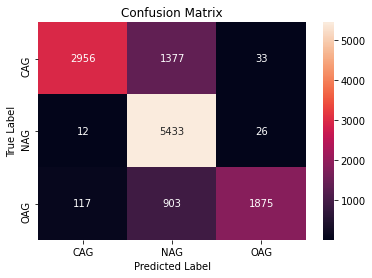

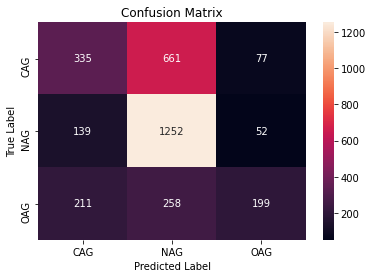

In [ ]:
#train random forest models using the best parameters for English
rf_en = RandomForestClassifier(n_estimators= 400, max_depth = 50, n_jobs = -1) ##PARAMS BASED ON OPTIMIZATION ABOVE
rf_model_en = rf_en.fit(X_train_vect_en, y_train)
y_pred_train = rf_model_en.predict(X_train_vect_en)
y_pred_test = rf_model_en.predict(X_test_vect_en)

#English training data matrix

cm = confusion_matrix(y_train, y_pred_train)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#English test data matrix
cm = confusion_matrix(y_test, y_pred_test)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [ ]:
#train random forest models using the best parameters for Hindi
rf_hi = RandomForestClassifier(n_estimators= 150, max_depth = 40, n_jobs = -1) ##PARAMS BASED ON OPTIMIZATION ABOVE
rf_model_hi = rf_hi.fit(X_train_vect_hi, y_train_hi)
y_pred_train = rf_model_hi.predict(X_train_vect_hi)
y_pred_test = rf_model_hi.predict(X_test_vect_hi)

#Hindi training data matrix
cm = confusion_matrix(y_train, y_pred_train)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#Hindi test data matrix
cm = confusion_matrix(y_test, y_pred_test)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


NameError: ignored

In [ ]:
#Characterlevel ngrams into tf-idf vectorization

#making ngrams tokens into string for tfidf vectorizer
english_total['ngram_5_text']=english_total['ngram_5'].apply(lambda x: "".join(x))
hindi_total['ngram_5_text']=hindi_total['ngram_5'].apply(lambda x: "".join(x))

X_ngram = english_total[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post',
 'ngram_5_text'
]]
y_ngram = english_total['agression']
X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram = train_test_split(X_ngram,y_ngram, test_size=0.2, random_state=42)

#TFIDF Vectorizer
tfidf_vect_ngram = TfidfVectorizer()
tfidf_vect_fit_ngram = tfidf_vect_ngram.fit(X_train_ngram['ngram_5_text'])

tfidf_train_ngram = tfidf_vect_fit_ngram.transform(X_train_ngram['ngram_5_text'])
tfidf_test_ngram = tfidf_vect_fit_ngram.transform(X_test_ngram['ngram_5_text'])

X_train_vect_en_ngram = pd.concat([X_train_ngram[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train_ngram.toarray())], axis=1)
X_test_vect_en_ngram = pd.concat([X_test_ngram[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test_ngram.toarray())], axis=1)


In [ ]:

X_hi_ngram = hindi_total[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post',
 'ngram_5_text'
]]
y_hi_ngram = hindi_total['agression']
X_train_hi_ngram, X_test_hi_ngram, y_train_hi_ngram, y_test_hi_ngram = train_test_split(X_hi_ngram,y_hi_ngram, test_size=0.2, random_state=42)

#TFIDF Vectorizer
tfidf_vect_hi_ngram = TfidfVectorizer()
tfidf_vect_fit_hi_ngram = tfidf_vect_ngram.fit(X_train_hi_ngram['ngram_5_text'])

tfidf_train_hi_ngram = tfidf_vect_fit_ngram.transform(X_train_hi_ngram['ngram_5_text'])
tfidf_test_hi_ngram = tfidf_vect_fit_ngram.transform(X_test_hi_ngram['ngram_5_text'])

X_train_vect_hi_ngram = pd.concat([X_train_hi_ngram[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train_hi_ngram.toarray())], axis=1)
X_test_vect_hi_ngram = pd.concat([X_test_hi_ngram[['emoji_sentiment',
 'number_of_emojis',
 'profanity_prob',
 'neg_score',
 'neutral_score',
 'pos_score',
 'compound_score',
 'punc_per_word',
 'exclamation_punc_per_word',
 'hashtags',
 'num_numbers',
 'num_capital_words',
 'num_words_in_post']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test_hi_ngram.toarray())], axis=1)


In [ ]:
#SVM with characterlevel vectorizing + feature extraction for English Data 
from sklearn import svm
clf_ngram = svm.SVC(kernel='RBF')
svm_model_en_ngram = clf_ngram.fit(X_train_vect_en_ngram, y_train_ngram)
y_pred_train_ngram = svm_model_en.predict(X_train_vect_en_ngram)
y_pred_test_ngram = svm_model_en.predict(X_test_vect_en_ngram)

#English training data matrix
cm = confusion_matrix(y_train_ngram, y_pred_train_ngram)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#English test data matrix
cm = confusion_matrix(y_test_ngram, y_pred_test_ngram)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



NameError: ignored

In [ ]:
#SVM with wordlevel vectorizing + feature extraction for English Data 
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

clf = svm.SVC(kernel='rbf')
clf = OneVsRestClassifier(BaggingClassifier(svm.SVC(kernel='rbf', probability=True, class_weight='auto'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf.fit(X, y)

svm_model_en = clf.fit(X_train_vect_en, y_train)
y_pred_train = svm_model_en.predict(X_train_vect_en)
y_pred_test = svm_model_en.predict(X_test_vect_en)

#English training data matrix
cm = confusion_matrix(y_train, y_pred_train)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#English test data matrix
cm = confusion_matrix(y_test, y_pred_test)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [ ]:
#SVM with wordlevel vectorizing + feature extraction for Hindi Data 
from sklearn import svm
clf = svm.SVC(kernel='RBF')
svm_model_en = clf.fit(X_train_vec, y_train)
y_pred_train = svm_model_en.predict(X_train_vect)
y_pred_test = svm_model_en.predict(X_test_vect)

#English training data matrix
cm = confusion_matrix(y_train, y_pred_train)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#English test data matrix
cm = confusion_matrix(y_test, y_pred_test)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [ ]:
#SVM with characterlevel vectorizing + feature extraction for Hindi Data 
clf_hi_ngram = svm.SVC(kernel='RBF')
svm_model_hi_ngram = clf.fit(X_train_vec_hi_ngram, y_train_hi_ngram)
y_pred_train_hi_ngram = svm_model_hi_ngram.predict(X_train_hi_vect_ngram)
y_pred_test_hi_ngram = svm_model_hi_ngram.predict(X_test_vect_hi_ngram)

#English training data matrix
cm = confusion_matrix(y_train_hi_ngram, y_pred_train_hi_ngram)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#English test data matrix
cm = confusion_matrix(y_test_hi_ngram, y_pred_test_hi_ngram)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
#Baseline - SVM RBF with characterlevel vectorizer and NO feature extraction
#English:
clf_hi_ngram = svm.SVC(kernel='RBF')
svm_model_hi_ngram_only = clf.fit(tfidf_train_ngram, y_train_hi_ngram)
y_pred_train_hi_ngram_only = svm_model_hi_ngram_only.predict(tfidf_train_ngram)
y_pred_test_hi_ngram_only = svm_model_hi_ngram_only.predict(tfidf_test_ngram)

#English training data matrix
cm = confusion_matrix(tfidf_train_ngram, y_pred_train_hi_ngram_only)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#English test data matrix
cm = confusion_matrix(tfidf_test_ngram, y_pred_test_hi_only)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#Hindi: 
clf_hi_ngram = svm.SVC(kernel='RBF')
svm_model_hi_ngram = clf.fit(X_train_vec_hi_ngram, y_train_hi_ngram)
y_pred_train_hi_ngram = svm_model_hi_ngram.predict(X_train_hi_vect_ngram)
y_pred_test_hi_ngram = svm_model_hi_ngram.predict(X_test_vect_hi_ngram)

#English training data matrix
cm = confusion_matrix(tfidf_train_hi_ngram, y_pred_train_hi_ngram)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#English test data matrix
cm = confusion_matrix(tfidf_test_hi_ngram, y_pred_test_hi_ngram)
class_label = ["CAG", "NAG", "OAG"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
